# Testing the advanced patch sampling schemes


1. PET SUV biased random sampling -- High intenity voxels are given high probability

2. GTV biased random sampling -- A region around GTV is given high probability, the PET foreground is given low probability and everything else is given zero probability

In [67]:
import os, time, math

import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torchio

import sys
sys.path.append('../')
from datasets.hecktor_petct_dataset import HECKTORPETCTDataset
from datautils.preprocessing import Preprocessor
from datautils.patch_sampling import PatchSampler3D
from datautils.visualization import NdimageVisualizer, display_image
from datautils.conversion import *

In [3]:
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFHN_rs113_hecktor_nii"
patient_id_filepath = "../hecktor_meta/patient_IDs_train.txt"

preprocessor = Preprocessor()

viz = NdimageVisualizer()

In [4]:
sample_idx = 0

PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training', 
                                     preprocessor=preprocessor,
                                     input_representation='separate-volumes', 
                                     augment_data=False)

sample_dict = PET_CT_dataset[sample_idx]
print(sample_dict['PET'].shape)
print(sample_dict['PET'].min())
print(sample_dict['PET'].max())

# For visualization purpose
PET_np = sample_dict['PET'].squeeze().permute(2,1,0)
CT_np = sample_dict['CT'].squeeze().permute(2,1,0)
target_labelmap_np = sample_dict['target-labelmap'].squeeze().permute(2,1,0)

torch.Size([1, 100, 450, 450])
tensor(0.)
tensor(20.)


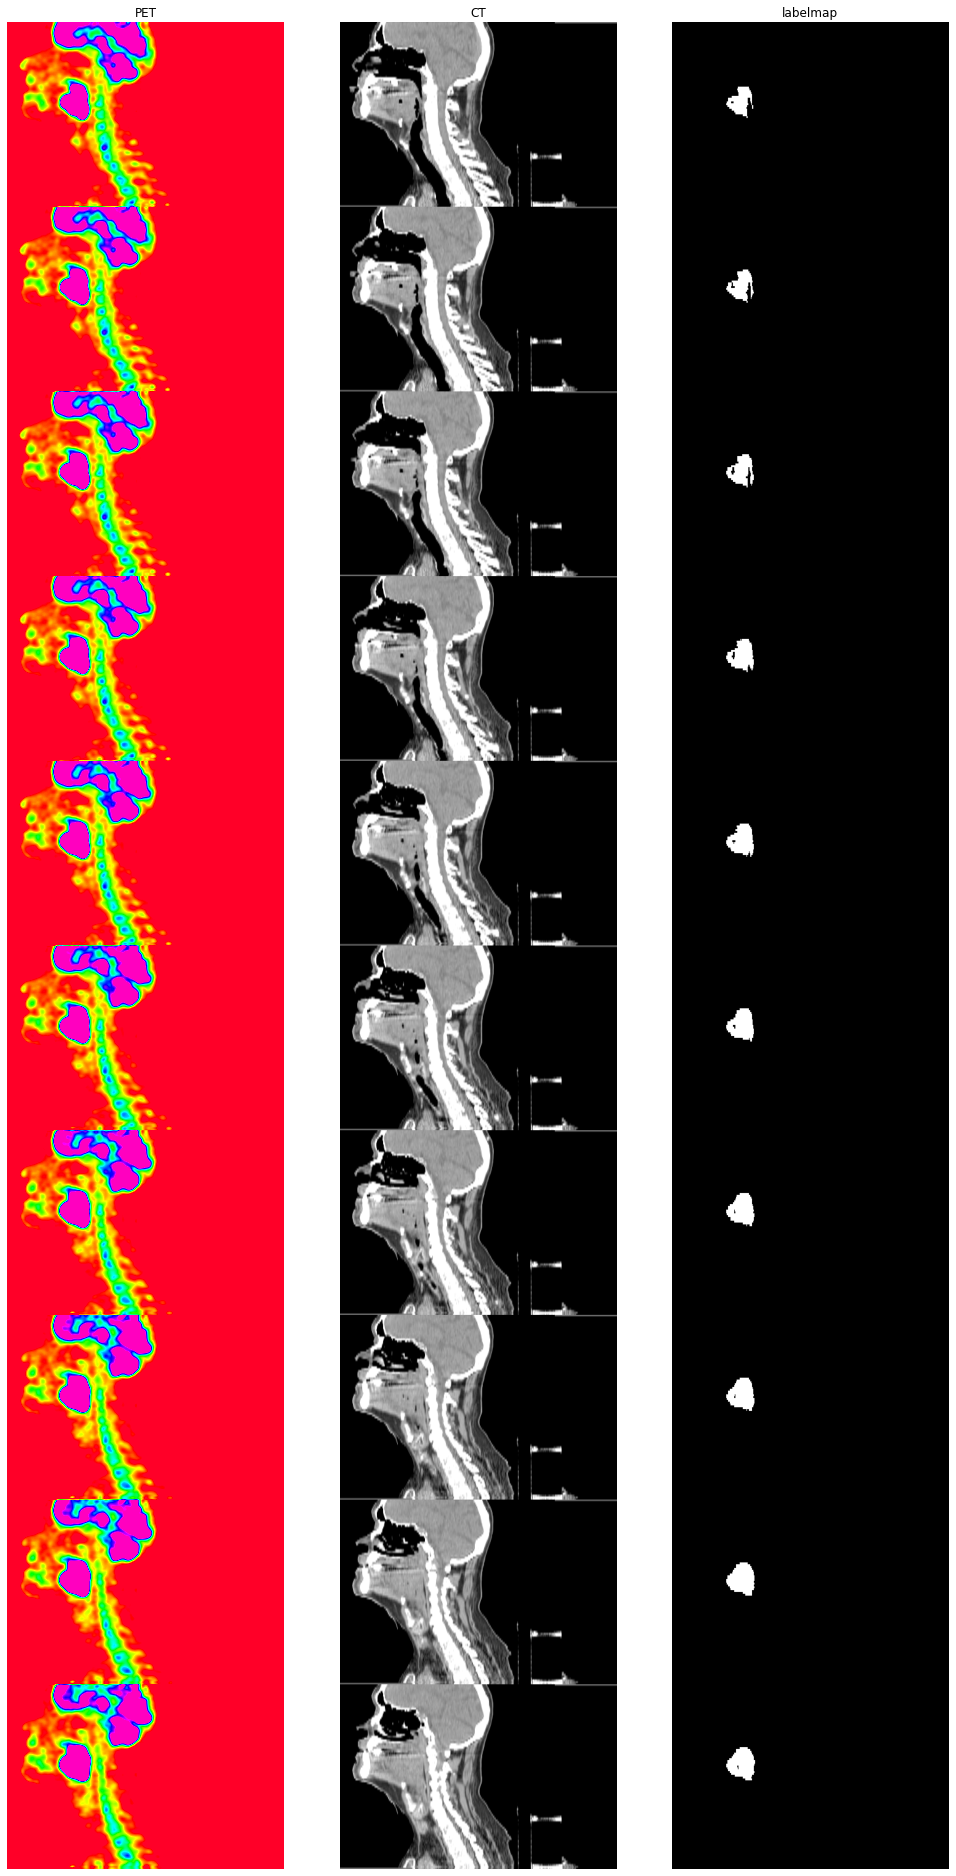

In [7]:
viz.multi_image_strips([PET_np, CT_np, target_labelmap_np],
                          image_types=['PET', 'CT', 'labelmap'],
                          idx_range=[230, 240],
                          view='sagittal',
                          subtitles=[])

## 1. SUV Biased Random Sampling

In [74]:
sampler = PatchSampler3D(patch_size=[128,128,32], 
                        volume_size=[450,450,100], 
                         sampling='high-suv-biased-random', 
                         focal_point_stride=[1,1,1], 
                         padding=[0,0,0])

samples_list, sampling_prob_map = sampler.get_samples(sample_dict, num_patches=8)

len(samples_list)

8

### Display the central axial slice of all patches

GTV voxels present in patch? True


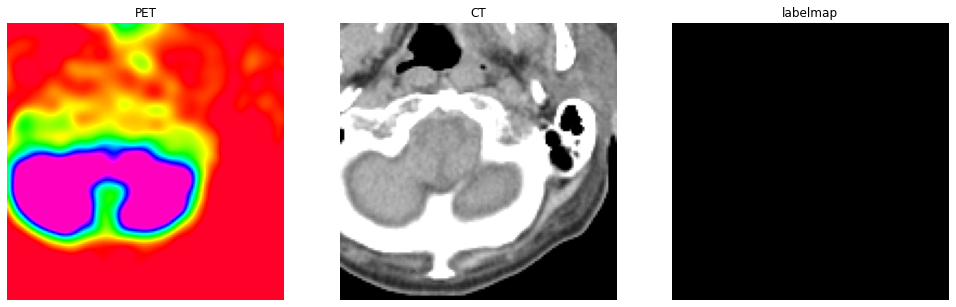

GTV voxels present in patch? False


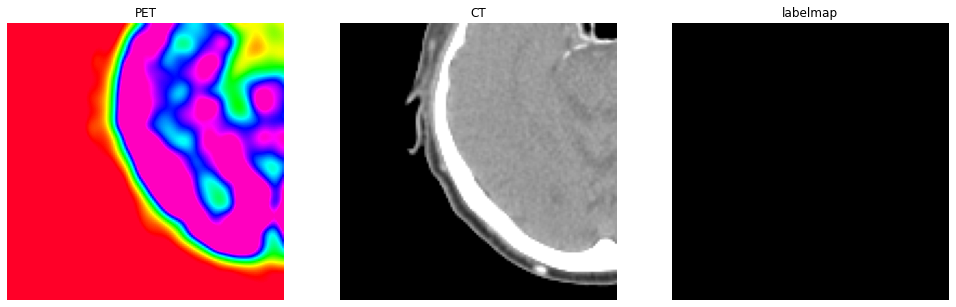

GTV voxels present in patch? True


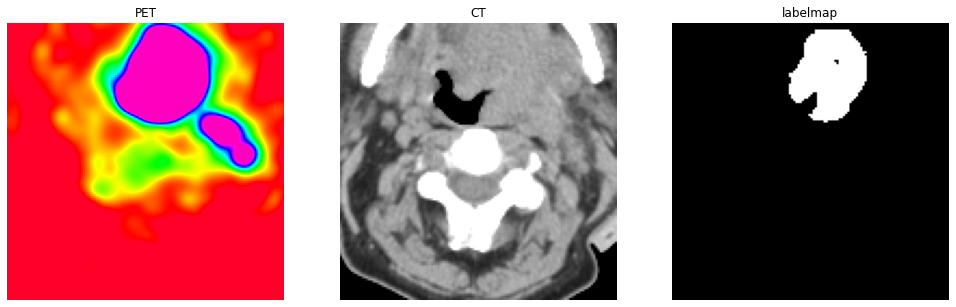

GTV voxels present in patch? True


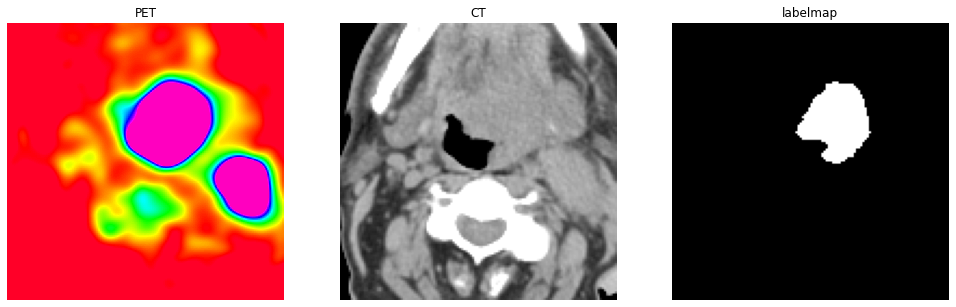

GTV voxels present in patch? True


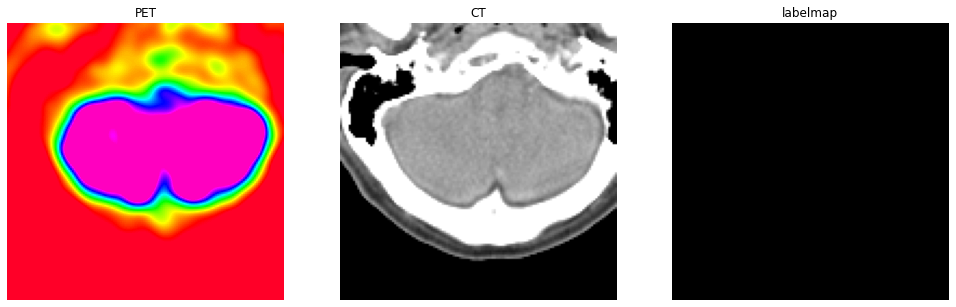

GTV voxels present in patch? True


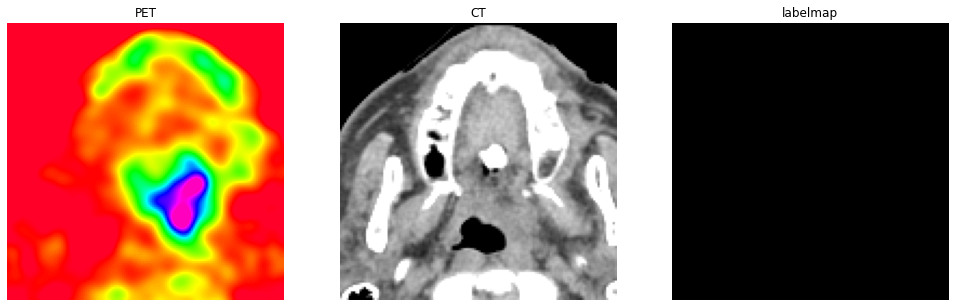

GTV voxels present in patch? True


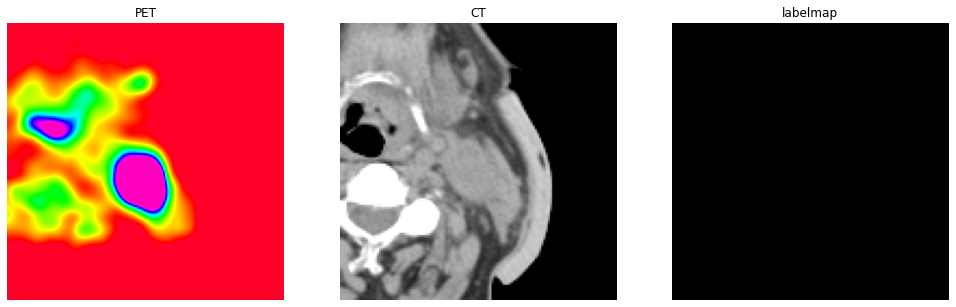

GTV voxels present in patch? False


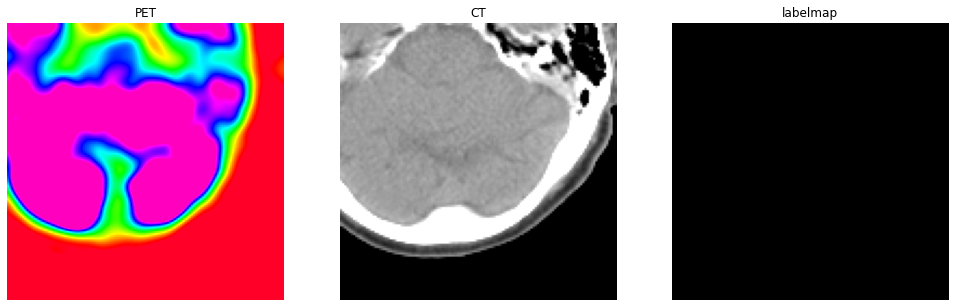

In [75]:
for sample_idx in range(len(samples_list)):
    PET_patch_np = samples_list[sample_idx]['PET'][0].permute(2,1,0).numpy()
    CT_patch_np = samples_list[sample_idx]['CT'][0].permute(2,1,0).numpy()
    target_labelmap_patch_np = samples_list[sample_idx]['target-labelmap'].permute(2,1,0).numpy()
    
    print("GTV voxels present in patch?", 1 in np.unique(target_labelmap_patch_np))
    
    viz.multi_image_strips([PET_patch_np, CT_patch_np, target_labelmap_patch_np],
                              image_types=['PET', 'CT', 'labelmap'],
                              idx_range=[15, 16],
                              view='axial',
                              subtitles=[])

### Dislay the sampling probability map

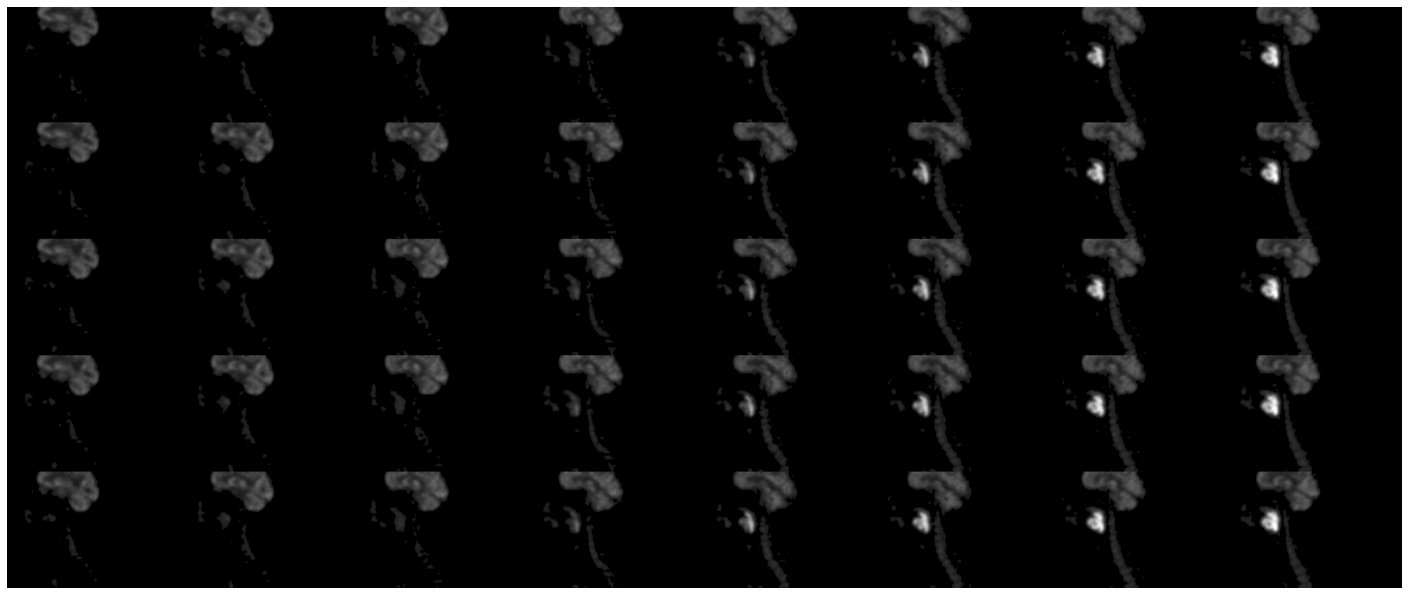

In [43]:
sampling_prob_map = sampling_prob_map.transpose(2,1,0)

viz.grid(sampling_prob_map, 
        idx_range=[200,240], 
        view='sagittal', 
        image_type='normalized', 
         title='')

## 2. GTV biased sampling, from PET foreground

In [76]:
sampler = PatchSampler3D(patch_size=[128,128,32], 
                        volume_size=[450,450,100], 
                         sampling='gtv-biased-fg-random', 
                         focal_point_stride=[1,1,1], 
                         padding=[0,0,0])

samples_list, sampling_prob_map = sampler.get_samples(sample_dict, num_patches=8)

len(samples_list)

16.0


8

### Display the central axial slice of all patches

GTV voxels present in patch? True


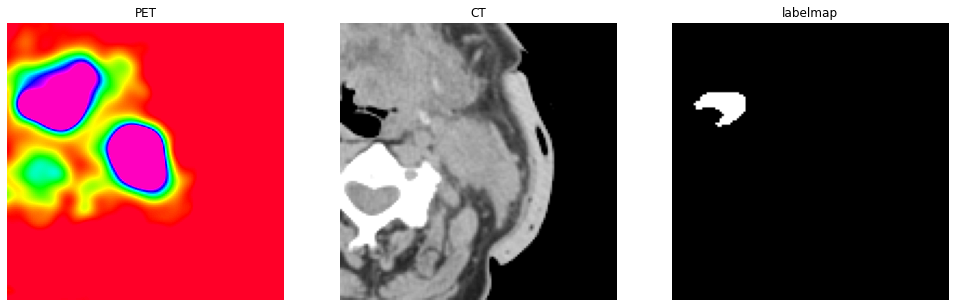

GTV voxels present in patch? True


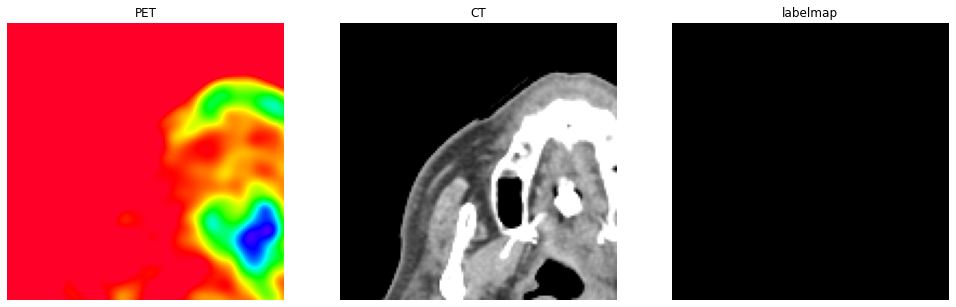

GTV voxels present in patch? True


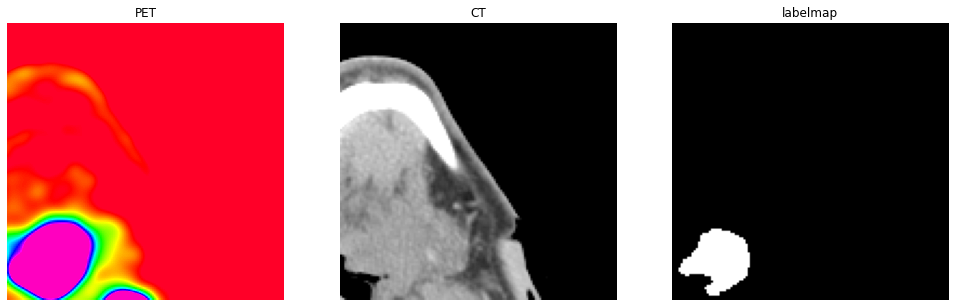

GTV voxels present in patch? True


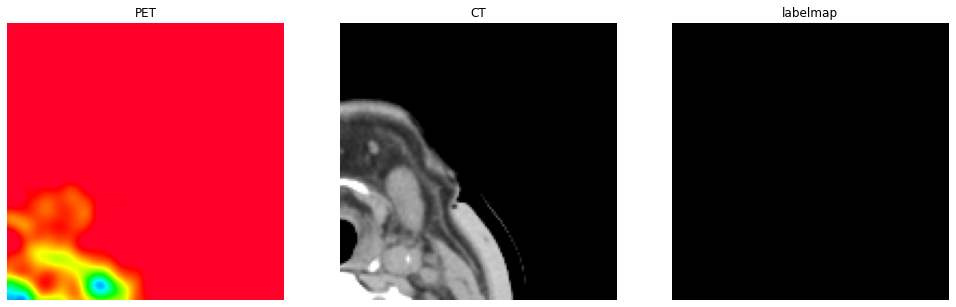

GTV voxels present in patch? True


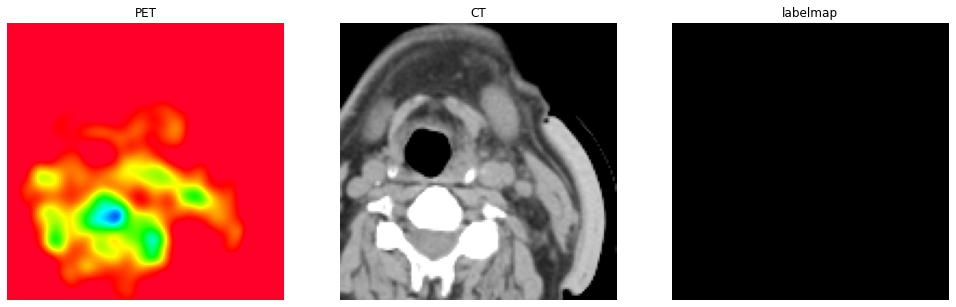

GTV voxels present in patch? True


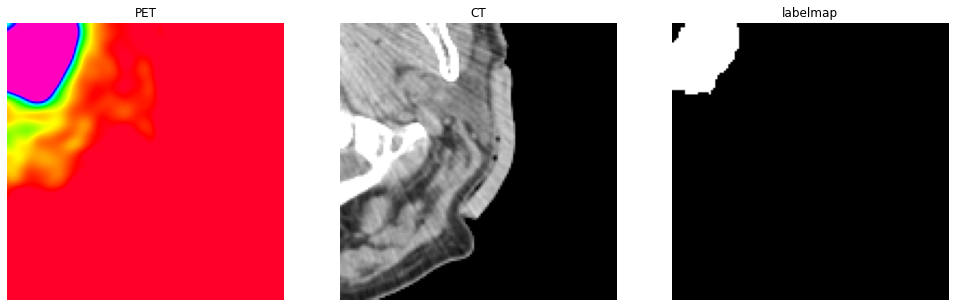

GTV voxels present in patch? True


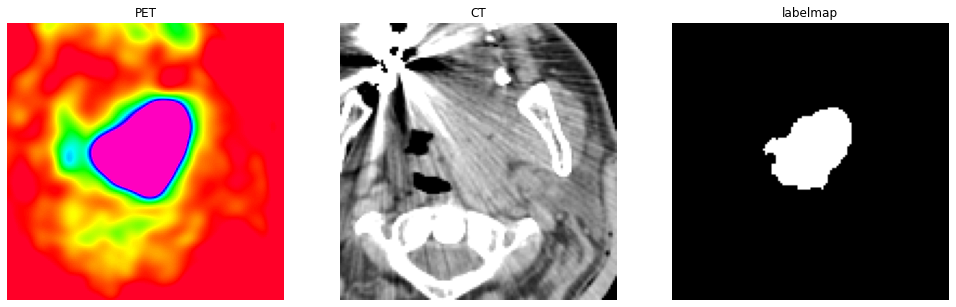

GTV voxels present in patch? True


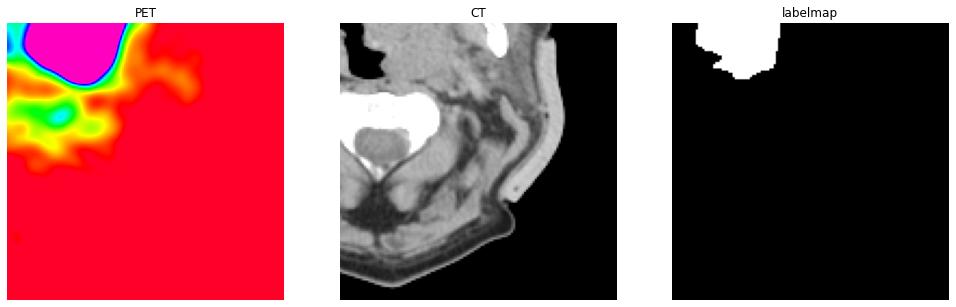

In [73]:
for sample_idx in range(len(samples_list)):
    PET_patch_np = samples_list[sample_idx]['PET'][0].permute(2,1,0).numpy()
    CT_patch_np = samples_list[sample_idx]['CT'][0].permute(2,1,0).numpy()
    target_labelmap_patch_np = samples_list[sample_idx]['target-labelmap'].permute(2,1,0).numpy()
    
    print("GTV voxels present in patch?", 1 in np.unique(target_labelmap_patch_np))
    
    viz.multi_image_strips([PET_patch_np, CT_patch_np, target_labelmap_patch_np],
                              image_types=['PET', 'CT', 'labelmap'],
                              idx_range=[15, 16],
                              view='axial',
                              subtitles=[])

### Dislay the sampling probability map

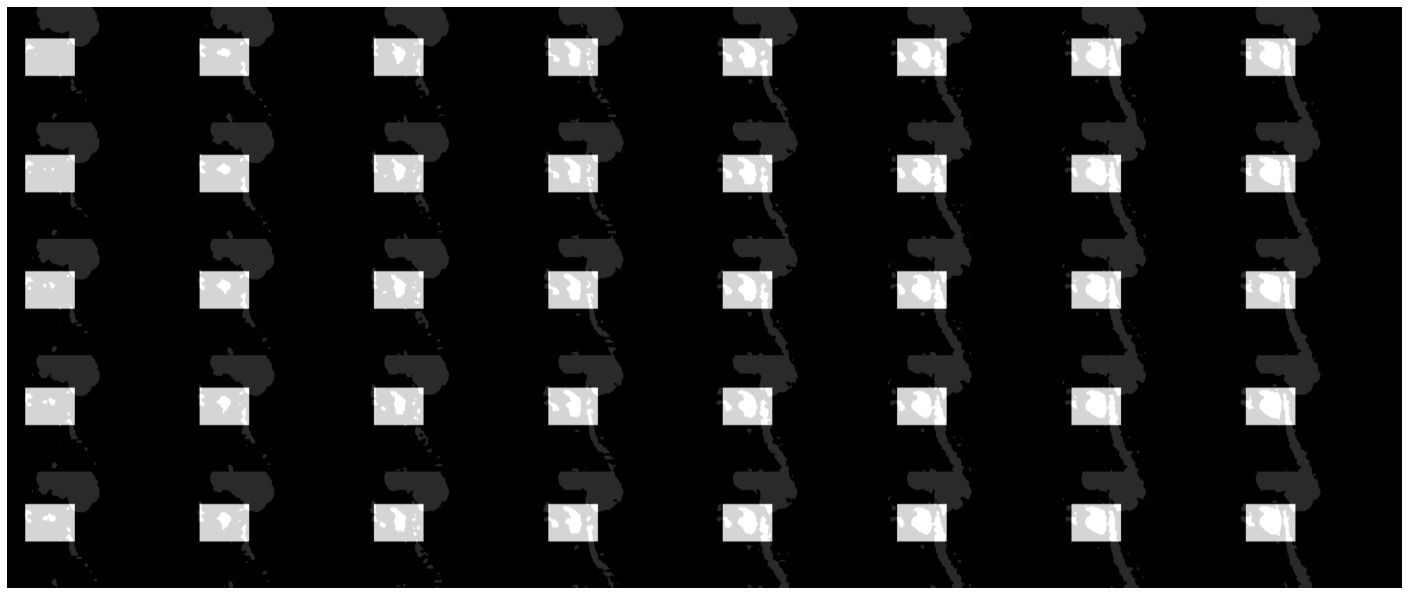

In [77]:
sampling_prob_map = sampling_prob_map.transpose(2,1,0)

viz.grid(sampling_prob_map, 
        idx_range=[200,240], 
        view='sagittal', 
        image_type='normalized', 
         title='')